# Notebook for unit tests

In [1]:
# Imports
import numpy as np
import pandas as pd
#import statsmodels.api as sm
from scipy.stats import chisquare
#import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, repeat
import pickle
import re
from math import exp, log

# Create R interface
# from rpy2.robjects.packages import importr
# import rpy2.robjects as ro

# stats = importr("stats")
# base = importr("base")

# Set Seaborn style
sns.set(style="whitegrid")
plt.style.use("ggplot")
sns.set_context("talk")
%matplotlib inline

## Test A1: Genetic drift and random mating

In [2]:
# Define the arrays containing results from
# simulation
files = [
    "a1simP10.pickle",
    "a1simP30.pickle",
    "a1simP50.pickle",
    "a1simP70.pickle",
    "a1simP100.pickle",
    "a1simP150.pickle",
    "a1simP200.pickle",
    "a1simP300.pickle",
    "a1simP400.pickle",
    "a1simP500.pickle",
]

prefix = "a1sim"
suffix = ".pickle"

# Define total number of simulations
totalSims = 100000

# Define max generation
maxGen = 100000

# Make sure that popSize is in same order
# as files array - 1st file should correspond
# to first popSize (population size)
popSize = np.asarray([10, 30, 50, 70, 100, 150, 200, 300, 400, 500])

# Load results from all the runs
# The results are stored as pickle
# files. Each containing a list of
# tuples
# Also create dataframes for each
# simulation run

columns = ["State", "Generations", "Transpositions"]
DataFrameSim = []
SimulationResults = {}
for filename in files:
    with open(filename, "rb") as f:
        SimulationResults[
            filename.replace(suffix, "").replace(prefix, "")
        ] = pickle.load(f)
        DataFrameSim.append(
            pd.DataFrame(
                [
                    x
                    for x in SimulationResults[
                        filename.replace(suffix, "").replace(
                            prefix, ""
                        )
                    ]
                ],
                columns=columns,
            )
        )

In [3]:
# Calculate reference statistics
refFrequency = 1 / (2 * popSize)
refFixation = popSize * 4
refFixSD = popSize * 2.15
refLoss = 2 * np.log(2 * popSize)

In [4]:
# Calculate simulation statistics
obsFrequency = []
obsFixation = []
obsFixSD = []
obsLoss = []
chisqr = []
chisqrCore = []
counter = 0
for df in DataFrameSim:
    dfFull = df[df["State"] == 1]
    dfLoss = df[df["State"] == 0]
    obsFrequency.append(dfFull.shape[0] / totalSims)
    obsFixation.append(dfFull["Generations"].mean())
    obsFixSD.append(dfFull["Generations"].std())
    obsLoss.append(dfLoss["Generations"].mean())
    chisqr.append(
        chisquare(
            [dfLoss.shape[0], dfFull.shape[0]],
            f_exp=[
                totalSims * (1 - refFrequency[counter]),
                totalSims * (refFrequency[counter]),
            ],
        )[0]
    )
    chisqrCore.append(
        chisquare(
            [dfLoss.shape[0], dfFull.shape[0]],
            f_exp=[
                totalSims * (1 - refFrequency[counter]),
                totalSims * (refFrequency[counter]),
            ],
        )
    )
    counter += 1
obsFrequency = np.asarray(obsFrequency)
obsFixation = np.asarray(obsFixation)
obsFixSD = np.asarray(obsFixSD)
obsLoss = np.asarray(obsLoss)

Text(0.5, 1.0, 'Observed frequency of TE fixation vs expected(1/2N)')

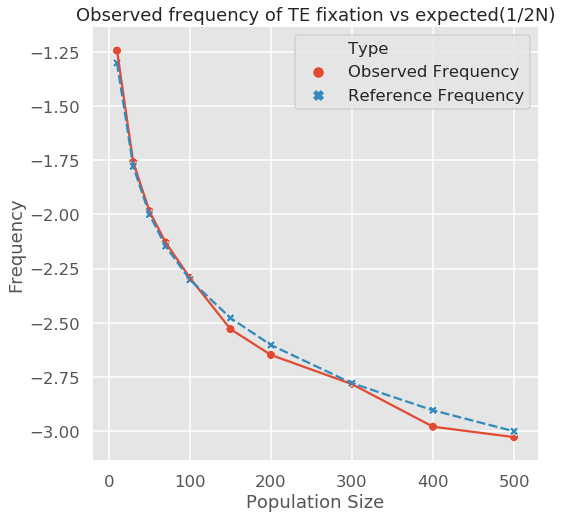

In [5]:
# Plot observed frequency vs expected frequency
# Creating a long form dataframe to do so
linePlotDF = pd.DataFrame(
    {
        "Population Size": popSize,
        "Observed Frequency": np.log10(obsFrequency),
        "Reference Frequency": np.log10(refFrequency),
    }
)

linePlotDF = pd.melt(
    linePlotDF,
    id_vars=["Population Size"],
    value_vars=["Observed Frequency", "Reference Frequency"],
)
linePlotDF.columns = ["Population Size", "Type", "Frequency"]

plt.figure(figsize=(8, 8))

sns.lineplot(
    x="Population Size",
    y="Frequency",
    hue="Type",
    style="Type",
    data=linePlotDF,
    legend=False,
)
sns.scatterplot(
    x="Population Size",
    y="Frequency",
    hue="Type",
    style="Type",
    data=linePlotDF,
).set_title("Observed frequency of TE fixation vs expected(1/2N)")

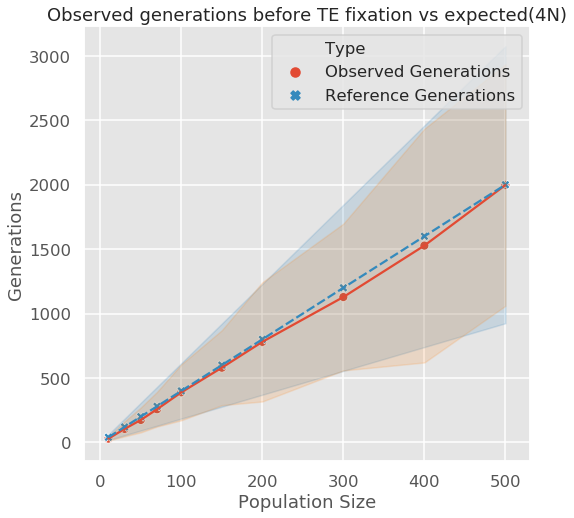

In [6]:
# Plot observed time for TE fixation vs expected
# Creating a long form dataframe to do so
linePlotDF = pd.DataFrame(
    {
        "Population Size": popSize,
        "Observed Generations": obsFixation,
        "Reference Generations": refFixation,
    }
)

linePlotDF = pd.melt(
    linePlotDF,
    id_vars=["Population Size"],
    value_vars=["Observed Generations", "Reference Generations"],
)
linePlotDF.columns = ["Population Size", "Type", "Generations"]

plt.figure(figsize=(8, 8))

sns.lineplot(
    x="Population Size",
    y="Generations",
    hue="Type",
    style="Type",
    data=linePlotDF,
    legend=False,
).set_title("Observed generations before TE fixation vs expected(4N)")
ax = sns.scatterplot(
    x="Population Size",
    y="Generations",
    hue="Type",
    style="Type",
    data=linePlotDF,
)

ax.fill_between(
    popSize,
    y1=refFixation - refFixSD,
    y2=refFixation + refFixSD,
    alpha=0.15,
    color="tab:blue",
)

ax.fill_between(
    popSize,
    y1=obsFixation - obsFixSD,
    y2=obsFixation + obsFixSD,
    alpha=0.15,
    color="tab:orange",
)

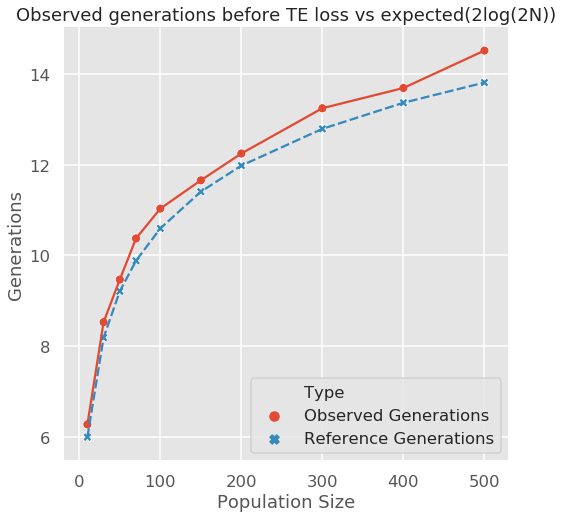

In [7]:
# Plot observed time for TE loss vs expected
# Creating a long form dataframe to do so
linePlotDF = pd.DataFrame(
    {
        "Population Size": popSize,
        "Observed Generations": obsLoss,
        "Reference Generations": refLoss,
    }
)

linePlotDF = pd.melt(
    linePlotDF,
    id_vars=["Population Size"],
    value_vars=["Observed Generations", "Reference Generations"],
)
linePlotDF.columns = ["Population Size", "Type", "Generations"]

plt.figure(figsize=(8, 8))

sns.lineplot(
    x="Population Size",
    y="Generations",
    hue="Type",
    style="Type",
    data=linePlotDF,
    legend=False,
).set_title(
    "Observed generations before TE loss vs expected(2log(2N))"
)

sns.scatterplot(
    x="Population Size",
    y="Generations",
    hue="Type",
    style="Type",
    data=linePlotDF,
)

In [8]:
obsLoss

array([ 6.27230405,  8.52919385,  9.46864516, 10.37498615, 11.0338426 ,
       11.65780711, 12.24958156, 13.2488506 , 13.69493969, 14.52072949])

In [9]:
refLoss

array([ 5.99146455,  8.18868912,  9.21034037,  9.88328485, 10.59663473,
       11.40756495, 11.98292909, 12.79385931, 13.36922346, 13.81551056])

Text(0.5, 1.0, 'Chi-square stastics for simulated populations')

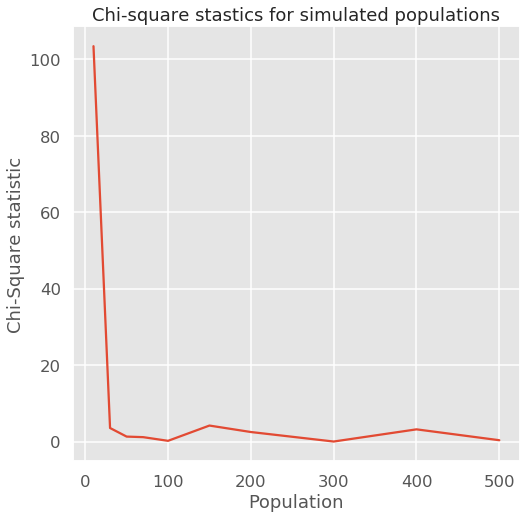

In [10]:
# Plot chisquare statistics

plt.figure(figsize=(8, 8))
ax = sns.lineplot(x=popSize, y=chisqr,)
ax.set(ylabel="Chi-Square statistic", xlabel="Population")
ax.set_title("Chi-square stastics for simulated populations")

In [11]:
chisqrCore

[Power_divergenceResult(statistic=103.45284210526316, pvalue=2.666665478935278e-24),
 Power_divergenceResult(statistic=3.5553220338982903, pvalue=0.05935478976151164),
 Power_divergenceResult(statistic=1.309090909090909, pvalue=0.2525593171851649),
 Power_divergenceResult(statistic=1.162618705035979, pvalue=0.28092310541372806),
 Power_divergenceResult(statistic=0.20100502512562815, pvalue=0.6539108387814259),
 Power_divergenceResult(statistic=4.1953177257525125, pvalue=0.040535756598403014),
 Power_divergenceResult(statistic=2.506265664160401, pvalue=0.11339435127837848),
 Power_divergenceResult(statistic=0.016694490818030587, pvalue=0.8971937289357101),
 Power_divergenceResult(statistic=3.2040050062578223, pvalue=0.0734581772328101),
 Power_divergenceResult(statistic=0.36036036036036034, pvalue=0.5483061686853479)]

In [10]:
refLoss

array([2.60205999, 3.5563025 , 4.        , 4.29225607, 4.60205999,
       4.95424251, 5.20411998, 5.5563025 , 5.80617997, 6.        ,
       6.29225607])

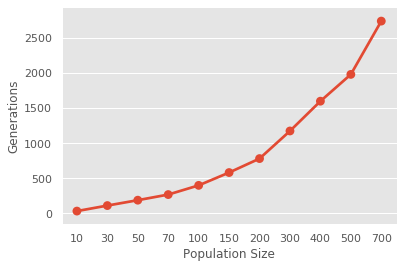

In [16]:
sns.pointplot(
    x="Population Size", y="Generations", errwidth=0, data=linePlotDF
)

## Test A2: Genetic drift and random mating; intermediate frequencies

In [2]:
# Create lambda functions
expectedA2lost = lambda N, p: -4 * N * (p / (1 - p)) * (log(p))
expectedA2fixed = lambda N, p: (-1 / p) * (
    4 * N * (1 - p) * (log(1 - p))
)

In [3]:
# Define population sizes
popSize = np.asarray([12, 32, 64])
# Define number of simulations
totalSims = 100000
# Define frequency
frequency = [0.5, 0.5, 0.5]
# Define files containing results
files = [
    "a2P12C0-0.pickle",
    "a2P32C0-0.pickle",
    "a2P64C0-0.pickle",
]

In [4]:
# Define test statistics
A2lost = []
A2fixed = []
for N, p in zip(popSize, frequency):
    A2lost.append(expectedA2lost(N, p))
    A2fixed.append(expectedA2fixed(N, p))

In [5]:
# Read the files
# Define dataframe columns
columns = [
    "State",
    "FixedTe",
    "TransientTE",
    "LostTE",
    "Generation",
    "TranspositionEvents",
]

# Empty arrays for storing simulation results
FixationEvents = []
LossEvents = []
FixedGenerations = []
LostGenerations = []
FixedGenerationsStd = []
LostGenerationsStd = []
# Read the simulation results
for i in files:
    with open(i, "rb") as f:
        b1Sim = pickle.load(f)
        b1SimDF = pd.DataFrame([x for x in b1Sim], columns=columns)
        b1SimDFLoss = b1SimDF[b1SimDF["State"] == "LOSS"]
        b1SimDFFull = b1SimDF[b1SimDF["State"] == "FIXED"]
        FixationEvents.append(b1SimDFFull.shape[0] / totalSims)
        LossEvents.append(b1SimDFLoss.shape[0] / totalSims)
        FixedGenerations.append(b1SimDFFull["Generation"].mean())
        LostGenerations.append(b1SimDFLoss["Generation"].mean())
        FixedGenerationsStd.append(b1SimDFFull["Generation"].std())
        LostGenerationsStd.append(b1SimDFLoss["Generation"].std())

In [6]:
FixationEvents

[0.50033, 0.50042, 0.49899]

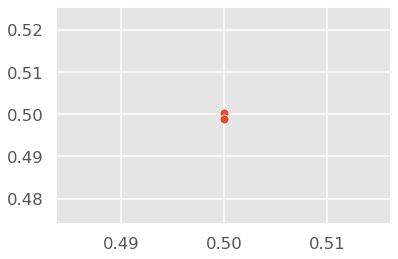

In [7]:
# Expected Frequencies vs observed frequencies
sns.scatterplot(x=frequency, y=FixationEvents)

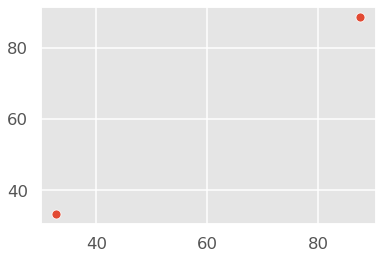

In [8]:
# Expected generations before fixation vs observed generations
sns.scatterplot(x=FixedGenerations, y=A2fixed)

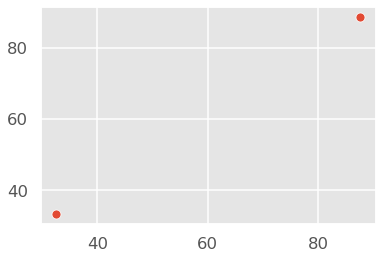

In [9]:
# Expected generations before loss vs observed generations
sns.scatterplot(x=LostGenerations, y=A2lost)

## Test B1: Genetic drift, random mating, and recombination

In [2]:
# Define the lambda functions
Lg1 = lambda N, c: (1) / (2 * N) - (c * (1 - (1) / (2 * N))) / (
    2 * N * c + 1
)
Lg2g3 = lambda N, c: (c * (1 - (1) / (2 * N))) / (2 * N * c + 1)
Lg4 = (
    lambda N, c: 1
    - (1) / (2 * N)
    - (c * (1 - (1) / (2 * N))) / (2 * N * c + 1)
)

In [3]:
# Define population sizes
popSize = np.asarray([10, 30, 50, 70, 100, 200, 300, 400])
# Define recombination rates
recombRates = [0.0, 0.1, 0.5]
# Define number of simulations
totalSims = 100000
# Define result containers
files = [
    "b1P10C0-0.pickle",
    "b1P10C0-1.pickle",
    "b1P10C0-5.pickle",
    "b1P30C0-0.pickle",
    "b1P30C0-1.pickle",
    "b1P30C0-5.pickle",
    "b1P50C0-0.pickle",
    "b1P50C0-1.pickle",
    "b1P50C0-5.pickle",
    "b1P70C0-0.pickle",
    "b1P70C0-1.pickle",
    "b1P70C0-5.pickle",
    "b1P100C0-0.pickle",
    "b1P100C0-1.pickle",
    "b1P100C0-5.pickle",
    "b1P200C0-0.pickle",
    "b1P200C0-1.pickle",
    "b1P200C0-5.pickle",
    "b1P300C0-0.pickle",
    "b1P300C0-1.pickle",
    "b1P300C0-5.pickle",
    "b1P400C0-0.pickle",
    "b1P400C0-1.pickle",
    "b1P400C0-5.pickle",
]

In [ ]:
# Define dataframe columns
# State defines the exit state for simulation instance
# where 0 = Transposon lost in all members of population
# and 1 = transposon fixed in all members of population
# and 2 = maximum generations reached without fixation or
# loss
columns = [
    "State",
    "FixedTe",
    "TransientTE",
    "LostTE",
    "Generation",
    "TranspositionEvents",
]

# Empty arrays for storing simulation results
Sg1 = []
Sg2 = []
Sg3 = []
Sg4 = []
# Read the simulation results
for i in files:
    with open(i, "rb") as f:
        b1Sim = pickle.load(f)
        b1SimDF = pd.DataFrame([x for x in b1Sim], columns=columns)
        b1SimDFLoss = b1SimDF[b1SimDF["State"] == "LOSS"]
        b1SimDFFull = b1SimDF[b1SimDF["State"] == "FIXED"]
        b1SimDFFull.loc[:, "NumberOfTransposons"] = b1SimDFFull[
            "FixedTe"
        ].map(lambda x: sum(x))
        Sg1.append(
            b1SimDFFull[
                b1SimDFFull["NumberOfTransposons"] == 3
            ].shape[0]
        )
        Sg2.append(
            b1SimDFFull[
                b1SimDFFull["NumberOfTransposons"] == 1
            ].shape[0]
        )
        Sg3.append(
            b1SimDFFull[
                b1SimDFFull["NumberOfTransposons"] == 2
            ].shape[0]
        )
        Sg4.append(b1SimDFLoss.shape[0])

In [5]:
# Calculate reference statistics
# g1 = both TEs are fixed
# g2 & g3 = Either TE1 or TE2
# g4 = no TEs
g1 = []
g2g3 = []
g4 = []

for N in popSize:
    for c in recombRates:
        g1.append(totalSims * Lg1(N, c))
        g2g3.append(totalSims * Lg2g3(N, c))
        g4.append(totalSims * Lg4(N, c))

In [6]:
# Create a unified dataframe to store the results
resultDF = pd.DataFrame(
    {
        "PopulationSize": list(
            chain.from_iterable(zip(*repeat(popSize, 3)))
        ),
        "RecombinationRates": recombRates * len(popSize),
        "TheoritcalBothTE": g1,
        "ObservedBothTE": Sg1,
        "TheoriticalTE1 & TE2": g2g3,
        "ObservedTE1": Sg2,
        "ObservedTE2": Sg3,
        # "TheoritcalNone": np.log(g4),
        # "ObservedNone": np.log(Sg4),
    }
)
# Melt the dataframe
resultDF = pd.melt(resultDF, ["PopulationSize", "RecombinationRates"])

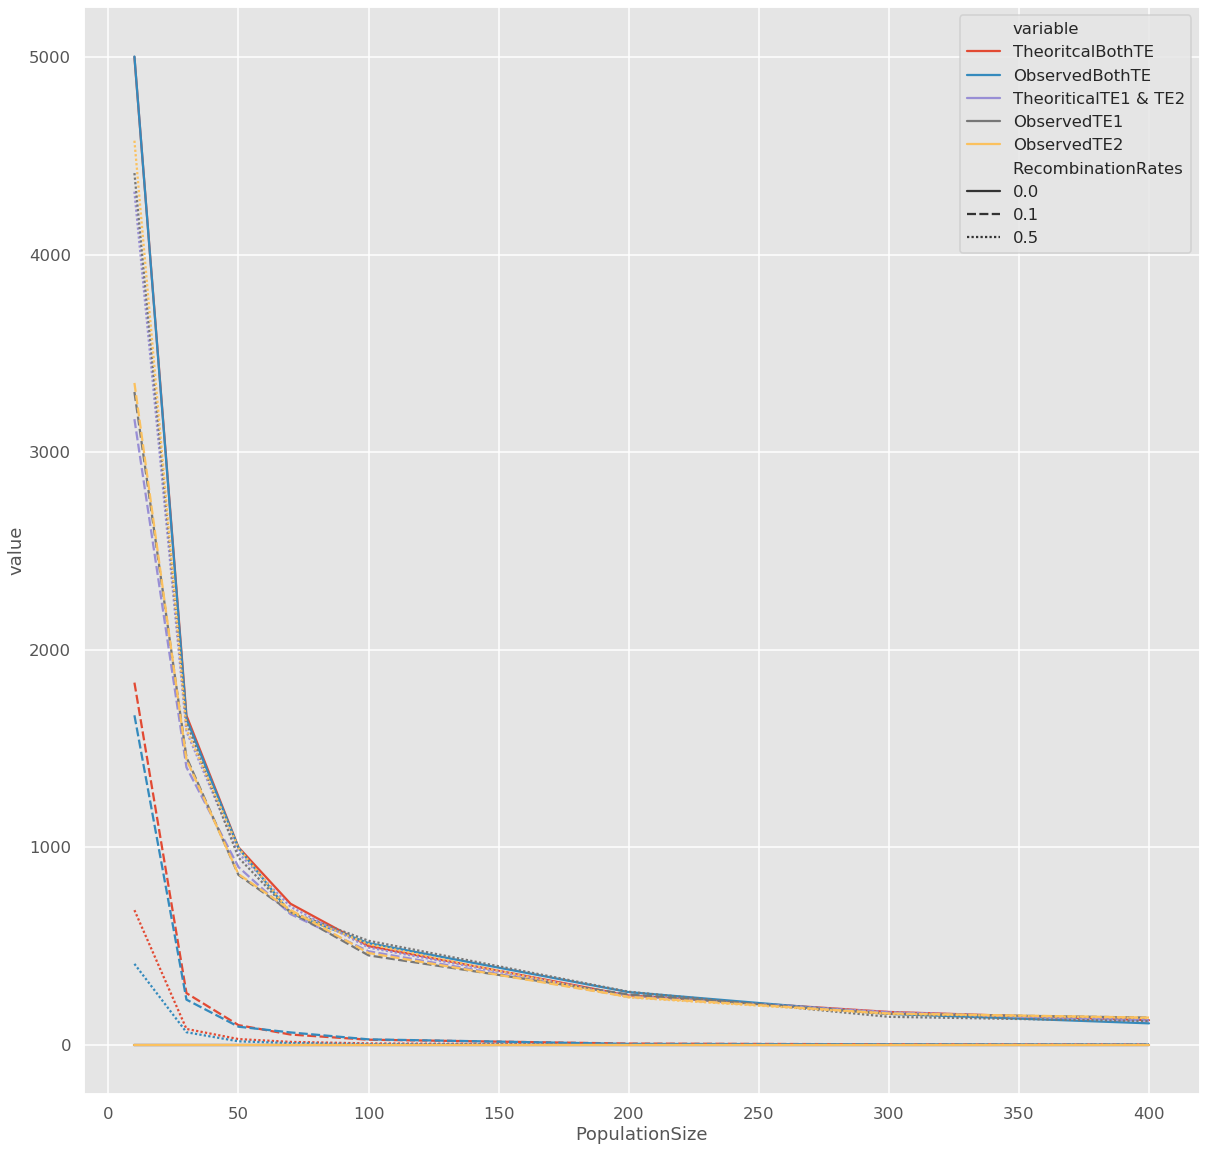

In [7]:
plt.figure(figsize=(20, 20))
ax = sns.lineplot(
    x="PopulationSize",
    y="value",
    hue="variable",
    style="RecombinationRates",
    data=resultDF,
)

In [8]:
# To make condition g2 & g3 more clear
resultDF = pd.DataFrame(
    {
        "PopulationSize": list(
            chain.from_iterable(zip(*repeat(popSize, 3)))
        ),
        "RecombinationRates": recombRates * len(popSize),
        "TheoritcalBothTE": g1,
        "ObservedBothTE": Sg1,
        "TheoriticalTE1+TE2": np.asarray(g2g3) + np.asarray(g2g3),
        "ObservedTE1 + TE2": np.asarray(Sg2) + np.asarray(Sg3),
        # "TheoritcalNone": np.log(g4),
        # "ObservedNone": np.log(Sg4),
    }
)
# Melt the dataframe
resultDF = pd.melt(resultDF, ["PopulationSize", "RecombinationRates"])

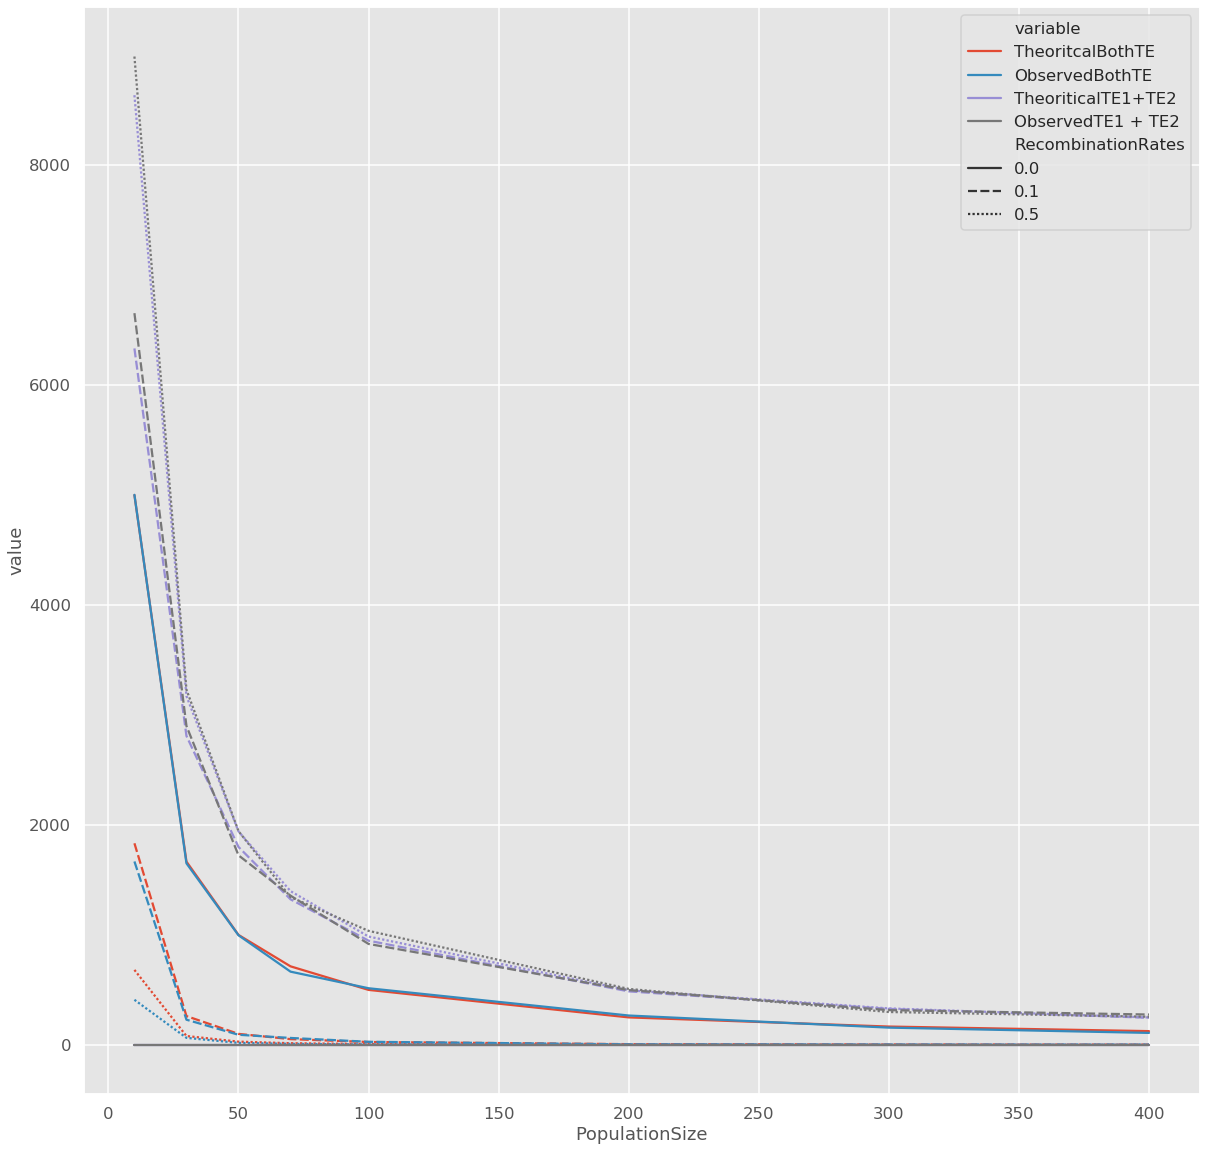

In [9]:
plt.figure(figsize=(20, 20))
ax = sns.lineplot(
    x="PopulationSize",
    y="value",
    hue="variable",
    style="RecombinationRates",
    data=resultDF,
)

In [11]:
# Print results in a table
resultDF = pd.DataFrame(
    {
        "PopulationSize": list(
            chain.from_iterable(zip(*repeat(popSize, 3)))
        ),
        "RecombinationRates": recombRates * len(popSize),
        "TheoritcalBothTE": g1,
        "ObservedBothTE": Sg1,
        "TheoriticalTE1 & TE2": g2g3,
        "ObservedTE1": Sg2,
        "ObservedTE2": Sg3,
        "TheoritcalNone": np.log(g4),
        "ObservedNone": np.log(Sg4),
    }
)
resultDF

,PopulationSize,RecombinationRates,TheoritcalBothTE,ObservedBothTE,TheoriticalTE1 & TE2,ObservedTE1,ObservedTE2,TheoritcalNone,ObservedNone
0,10,0.0,5000.000000,5002,0.000000,0,0,11.461632,11.461611
1,10,0.1,1833.333333,1668,3166.666667,3304,3350,11.427731,11.426038
2,10,0.5,681.818182,410,4318.181818,4412,4576,11.415112,11.414232
3,30,0.0,1666.666667,1651,0.000000,0,0,11.496118,11.496278
4,30,0.1,261.904762,229,1404.761905,1456,1444,11.481730,11.481135
5,30,0.5,80.645161,64,1586.021505,1633,1597,11.479858,11.479431
6,50,0.0,1000.000000,997,0.000000,0,0,11.502875,11.502905
7,50,0.1,100.000000,92,900.000000,860,864,11.493743,11.494599
8,50,0.5,29.411765,18,970.588235,948,996,11.493023,11.493110
9,70,0.0,714.285714,666,0.000000,0,0,11.505757,11.506243


## Test C1: Genetic drift, selection

In [2]:
# Create lambda functions
expectedC1 = lambda N, s, p: (1 - exp(-4 * N * s * p)) / (
    1 - exp(-4 * N * s)
)

In [3]:
# Define population sizes
popSize = np.asarray([50])
# Define number of simulations
totalSims = 100000
# Define the selection values
selection = [-0.01, 0.0000000001, 0.01, 0.05]
# Define frequency
frequency = [0.2, 0.2, 0.2, 0.2]
# Define result containers
files = [
    "c1P50C1-01.pickle",
    "c1P50C0-00.pickle",
    "c1P50C0-01.pickle",
    "c1P50C0-05.pickle",
]

In [4]:
# Define dataframe columns
columns = [
    "State",
    "FixedTe",
    "TransientTE",
    "LostTE",
    "Generation",
    "TranspositionEvents",
]

# Empty arrays for storing simulation results
FixationEvents = []
# Read the simulation results
for i in files:
    with open(i, "rb") as f:
        b1Sim = pickle.load(f)
        b1SimDF = pd.DataFrame([x for x in b1Sim], columns=columns)
        b1SimDFLoss = b1SimDF[b1SimDF["State"] == "LOSS"]
        b1SimDFFull = b1SimDF[b1SimDF["State"] == "FIXED"]
        FixationEvents.append(b1SimDFFull.shape[0] / totalSims)

In [5]:
expectedFixationNo = []
for N, p in zip(popSize, frequency):
    for s in selection:
        expectedFixationNo.append(expectedC1(N, s, p))

In [6]:
# Convert the results into a dataframe
resultDF = pd.DataFrame(
    {
        "PopulationSize": list(
            chain.from_iterable(zip(*repeat(popSize, 4)))
        ),
        "SelectionCoefficient": selection * len(popSize),
        "Frequency": list(
            chain.from_iterable(zip(*repeat(frequency, 1)))
        ),
        "ObservedFixationEvents": FixationEvents,
        "TheoriticalFrequency": expectedFixationNo,
    }
)

In [7]:
# Melting dataframe to longform
linePlotDF = pd.melt(
    resultDF,
    id_vars=["SelectionCoefficient", "PopulationSize"],
    value_vars=["ObservedFixationEvents", "TheoriticalFrequency"],
)
linePlotDF["PopulationSize"] = [
    "$%s$" % x for x in linePlotDF["PopulationSize"]
]

[Text(0, 0.5, 'Observed fixation events')]

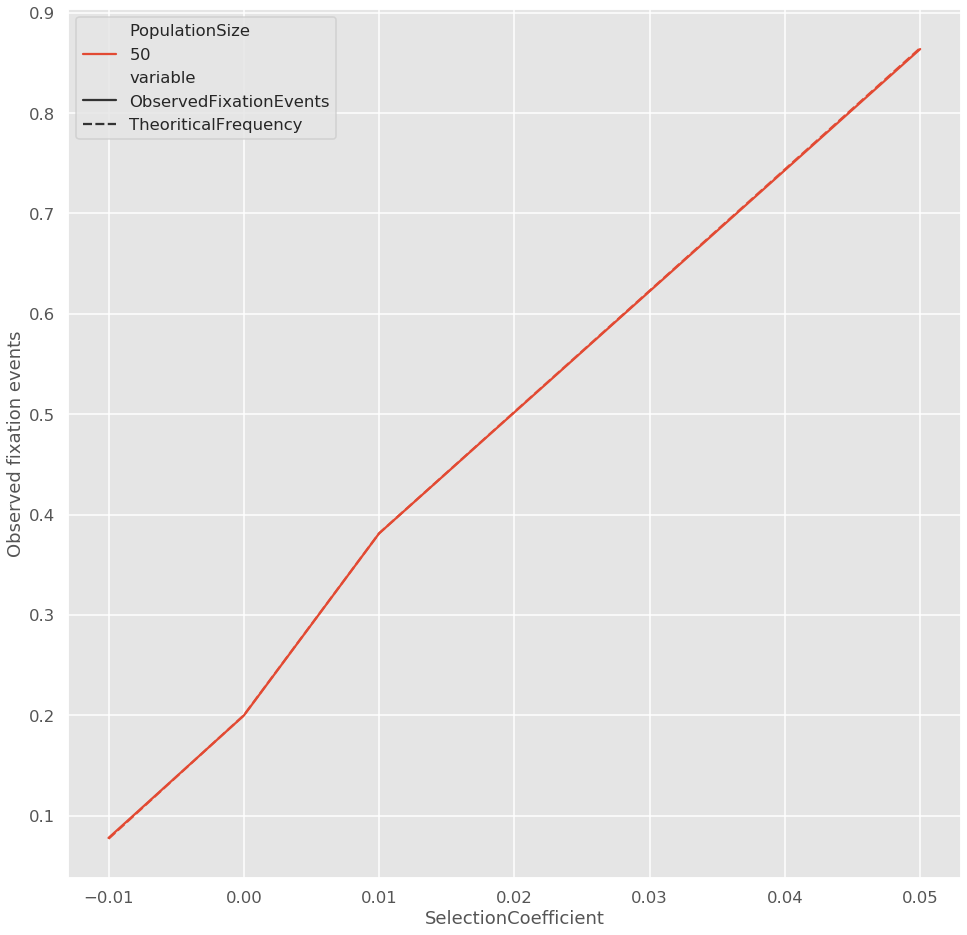

In [8]:
plt.figure(figsize=(16, 16))
ax = sns.lineplot(
    x="SelectionCoefficient",
    y="value",
    hue="PopulationSize",
    data=linePlotDF,
    style="variable",
)
ax.set(ylabel="Observed fixation events")

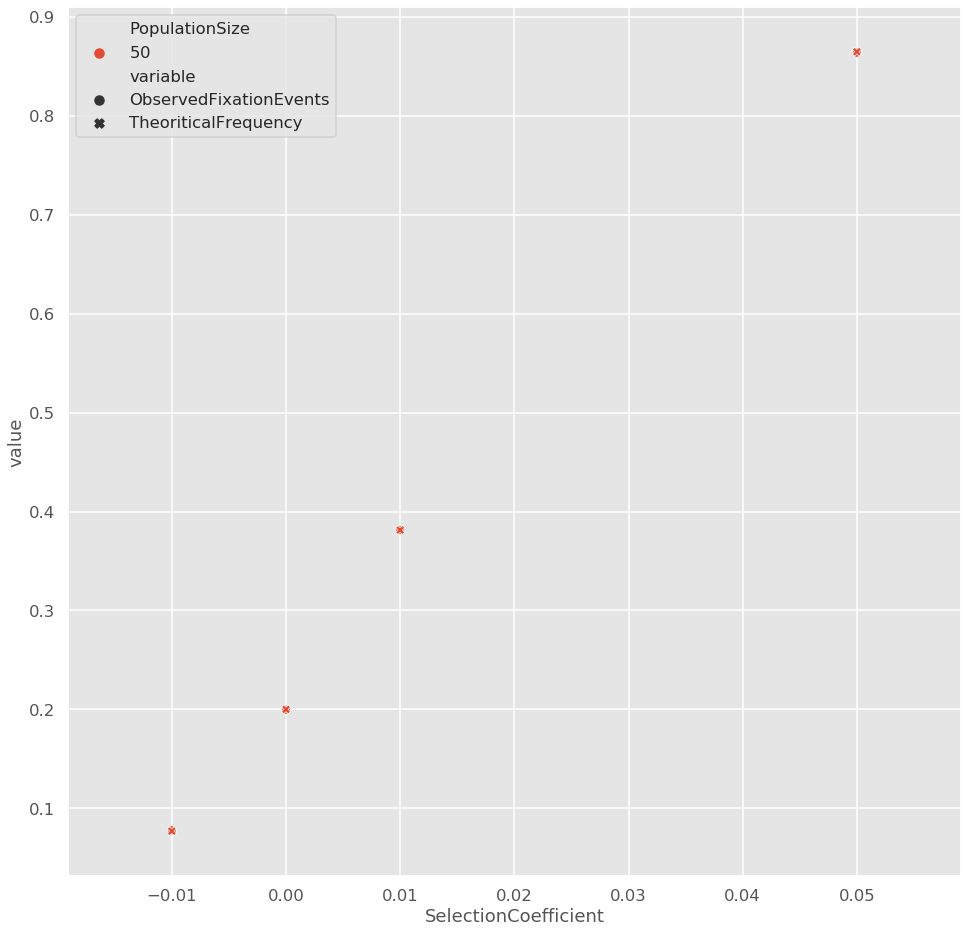

In [9]:
plt.figure(figsize=(16, 16))
ax = sns.scatterplot(
    x="SelectionCoefficient",
    y="value",
    hue="PopulationSize",
    data=linePlotDF,
    style="variable"
)

In [10]:
resultDF

,PopulationSize,SelectionCoefficient,Frequency,ObservedFixationEvents,TheoriticalFrequency
0,50,-1.000000e-02,0.2,0.07780,0.076979
1,50,1.000000e-10,0.2,0.19970,0.200000
2,50,1.000000e-02,0.2,0.38117,0.381281
3,50,5.000000e-02,0.2,0.86372,0.864704


## Test D1: transposition

In [2]:
# Create lambda functions
expectedD1 = lambda N, u, t: (log(1+u)*t) + log(N)

In [3]:
# Define population sizes
popSize = np.asarray([100,200])
# Define number of simulations
totalSims = 1000
# Define transposition rate
transpositionRate = [0.02,0.02]
# Define result containers
files = [
    "d1P100u02.pickle",
]

In [4]:
# Define dataframe columns
columns = [
    "State",
    "FixedTe",
    "TransientTE",
    "LostTE",
    "Generation",
    "TranspositionEvents",
    "AverageCopyNumber"
]

# Empty arrays for storing simulation results
FixationEvents = []
# Read the simulation results
for i in files:
    with open(i, "rb") as f:
        b1Sim = pickle.load(f)
        b1SimDF = pd.DataFrame([x for x in b1Sim], columns=columns)
        b1SimDFLoss = b1SimDF[b1SimDF["State"] == "LOSS"]
        b1SimDFFull = b1SimDF[b1SimDF["State"] == "FIXED"]
        b1SimDFFull['ExpectedResult'] = (log(1+0.02)*b1SimDFFull['Generation']) + log(100)

/home/xerien/miniforge-pypy3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
b1SimDF

,State,FixedTe,TransientTE,LostTE,Generation,TranspositionEvents,AverageCopyNumber
0,FIXED,[1],[],[],109,1536.5,10.9
1,FIXED,[1],[],[],68,600.5,5.28
2,LOSS,[],[],[],87,134.0,"[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [..."
3,FIXED,[1],[],[],85,1011.5,9.29
4,FIXED,[1],[],[],215,2837.0,12.21
...,...,...,...,...,...,...,...
995,FIXED,[1],[],[],52,384.5,4.23
996,FIXED,[1],[],[],95,1469.0,14.34
997,FIXED,[1],[],[],159,1464.5,9.05
998,FIXED,[1],[],[],110,1491.5,13.51
